In [40]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
os.makedirs(outdir, exist_ok=True)

## Loading the gencode reference

In [114]:
gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
gencode = gencode.iloc[:, [5,6]]
gencode.set_index(6, inplace=True)
gencode = gencode.squeeze()
gencode = gencode.to_dict()

In [144]:
gencode['AP003774.1']

'ENSG00000181908'

## Loading the coloc data 

In [116]:
data = []
coloc_glob = 'results/main/coloc/Results/Colocalization_SMKN/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
coloc_fns = sorted(glob.glob(coloc_glob))

In [117]:
for fn in coloc_fns:
    
    df = pd.read_table(fn)
    
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]

    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    
    data.append(df)

In [118]:
all_data = pd.concat(data)

# add the gene name
all_data['gene_name'] = all_data.geneName.replace(gencode)

## Check data sources

In [119]:
check_sources = all_data.drop_duplicates(['eqtl', 'ge'])
check_sources = check_sources[['eqtl', 'ge']]

In [120]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index('eqtl'))
pd.set_option('display.max_rows', 20) 

,ge
eqtl,
BLUEPRINT,T-cell
BLUEPRINT,monocyte
BLUEPRINT,neutrophil
GTEx,LCL
Quach_2016,monocyte_IAV
Quach_2016,monocyte_Pam3CSK4
Quach_2016,monocyte_R848
Schmiedel_2018,B-cell_naive
Schmiedel_2018,CD4_T-cell_anti-CD3-CD28


## Extract expression sources revelant to T1D

In [121]:
t1d_ge_sources = [
 'B-cell_naive',
 'CD4_T-cell_anti-CD3-CD28',
 'CD4_T-cell_naive',
 'CD8_T-cell_anti-CD3-CD28',
 'CD8_T-cell_naive',
 'NK-cell_naive',
 'T-cell',
 'Tfh_memory',
 'Th1-17_memory',
 'Th17_memory',
 'Th1_memory',
 'Th2_memory',
 'Treg_memory',
 'Treg_naive',
 'monocyte_CD16_naive',
 'monocyte_IAV',
 'monocyte_LPS',
 'monocyte_Pam3CSK4',
 'monocyte_R848',
 'monocyte_naive',
 'neutrophil',
 'LCL',
 'blood',
 'pancreas',
 'pancreatic_islet']

In [122]:
for x in t1d_ge_sources:
    print(x)

B-cell_naive
CD4_T-cell_anti-CD3-CD28
CD4_T-cell_naive
CD8_T-cell_anti-CD3-CD28
CD8_T-cell_naive
NK-cell_naive
T-cell
Tfh_memory
Th1-17_memory
Th17_memory
Th1_memory
Th2_memory
Treg_memory
Treg_naive
monocyte_CD16_naive
monocyte_IAV
monocyte_LPS
monocyte_Pam3CSK4
monocyte_R848
monocyte_naive
neutrophil
LCL
blood
pancreas
pancreatic_islet


In [123]:
for i, sr in check_sources.iterrows():
    print('\t'.join(sr.to_list()))

BLUEPRINT	T-cell
BLUEPRINT	monocyte
BLUEPRINT	neutrophil
GTEx	LCL
Quach_2016	monocyte_IAV
Quach_2016	monocyte_Pam3CSK4
Quach_2016	monocyte_R848
Schmiedel_2018	B-cell_naive
Schmiedel_2018	CD4_T-cell_anti-CD3-CD28
Schmiedel_2018	CD4_T-cell_naive
Schmiedel_2018	CD8_T-cell_anti-CD3-CD28
Schmiedel_2018	CD8_T-cell_naive
Schmiedel_2018	NK-cell_naive
Schmiedel_2018	Tfh_memory
Schmiedel_2018	Th1-17_memory
Schmiedel_2018	Th17_memory
Schmiedel_2018	Th1_memory
Schmiedel_2018	Th2_memory
Schmiedel_2018	Treg_memory
Schmiedel_2018	Treg_naive
van_de_Bunt_2015	pancreatic_islet


In [124]:
for x in t1d_ge_sources:
    print(x)

B-cell_naive
CD4_T-cell_anti-CD3-CD28
CD4_T-cell_naive
CD8_T-cell_anti-CD3-CD28
CD8_T-cell_naive
NK-cell_naive
T-cell
Tfh_memory
Th1-17_memory
Th17_memory
Th1_memory
Th2_memory
Treg_memory
Treg_naive
monocyte_CD16_naive
monocyte_IAV
monocyte_LPS
monocyte_Pam3CSK4
monocyte_R848
monocyte_naive
neutrophil
LCL
blood
pancreas
pancreatic_islet


In [125]:
t1d_data = all_data.copy() #loc[all_data['ge'].isin(t1d_ge_sources)]

In [126]:
# filtering on the pp_H4_Coloc_Summary
t1d_data = t1d_data.loc[t1d_data.pp_H4_Coloc_Summary > 0.75]

In [127]:
t1d_data

,chr,pos,pp_H0_Coloc_Summary,pp_H1_Coloc_Summary,pp_H2_Coloc_Summary,pp_H3_Coloc_Summary,pp_H4_Coloc_Summary,rs_id,variant_id,geneName,...,AN,slope_se_snp,slope_gwas,slope_se_gwas,pval_nominal,SampleSize,gwas,eqtl,ge,gene_name
0,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000052802,...,5008,0.439754,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000052802
1,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000170088,...,5008,0.998096,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000170088
2,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000183439,...,5008,0.018893,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000183439
3,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000250486,...,5008,0.189897,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000250486
4,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000109466,...,5008,1.087390,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000109466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000258620,...,5008,0.022002,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000258620
34,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000225746,...,5008,0.073416,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000225746
35,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000214548,...,5008,0.022416,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000214548
36,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000258663,...,5008,0.023521,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000258663


## Plotting study summary

In [128]:
study_summary = t1d_data.value_counts(['gwas', 'eqtl', 'ge']).to_frame().reset_index()
study_summary.rename(columns={0:'count'}, inplace=True)

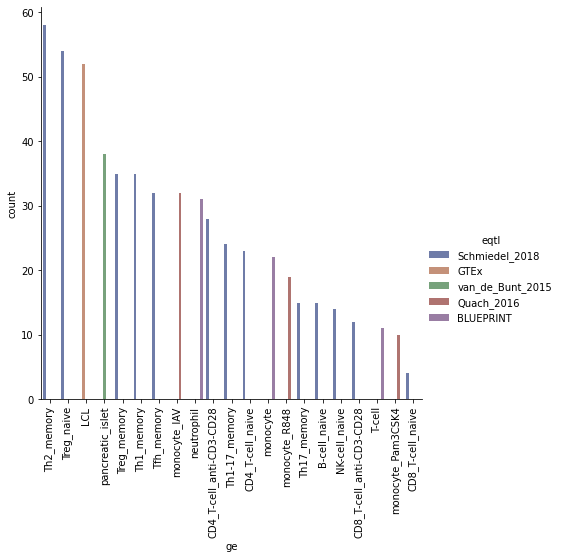

In [129]:
#sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)

# fig, ax = plt.subplots()
# Draw a nested barplot by species and sex
g= sns.catplot(data=study_summary, kind="bar",
            x="ge", y="count", hue="eqtl",
            ci="sd", palette="dark", alpha=.6, height=6)

for x in g.ax.get_xticklabels():
    x.set_rotation(90)

In [130]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Gene Summary

In [131]:
gene_summary = t1d_data.groupby(['gwas', 'eqtl', 'ge']).gene_name.value_counts()

In [132]:
pd.set_option('display.max_rows', gene_summary.shape[0]) 
display(gene_summary.to_frame())
pd.set_option('display.max_rows', 20) 

gene_name
gwas                 eqtl             ge                       gene_name                 
T1D_34012112_Gaulton BLUEPRINT        T-cell                   ENSG00000052802          1
                                                               ENSG00000109466          1
                                                               ENSG00000150637          1
                                                               ENSG00000170088          1
                                                               ENSG00000170677          1
                                                               ENSG00000176225          1
                                                               ENSG00000183439          1
                                                               ENSG00000250486          1
                                                               ENSG00000263417          1
                                                               ENSG00000266840          1
                                                               ENSG00000273584          1
                                      monocyte                 ENSG00000026103          1
                                                               ENSG00000107789          1
                                                               ENSG00000107796          1
                                                               ENSG00000112679          1
                                                               ENSG00000112685          1
                                                               ENSG00000119922          1
                                                               ENSG00000137265          1
                                                               ENSG00000138134          1
                                                               ENSG00000138135          1
                                                               ENSG00000138138          1
                                                               ENSG00000152766          1
                                                               ENSG00000171862          1
                                                               ENSG00000180139          1
                                                               ENSG00000184719          1
                                                               ENSG00000188996          1
                                                               ENSG00000198682          1
                                                               ENSG00000204020          1
                                                               ENSG00000223482          1
                                                               ENSG00000224745          1
                                                               ENSG00000227268          1
                                                               ENSG00000272463          1
                                                               ENSG00000286116          1
                                      neutrophil               ENSG00000034713          1
                                                               ENSG00000065427          1
                                                               ENSG00000065457          1
                                                               ENSG00000080298          1
                                                               ENSG00000090863          1
                                                               ENSG00000096968          1
                                                               ENSG00000103035          1
                                                               ENSG00000103091          1
                                                               ENSG00000106993          1
                                                               ENSG00000107249          1
                              

In [133]:
t1d_data.shape

(564, 28)

In [134]:
t1d_data.drop_duplicates(['eqtl', 'ge', 'gene_name']).shape

(541, 28)

In [135]:
t1d_data.gene_name.value_counts().to_frame()

,gene_name
ENSG00000197635,8
ENSG00000115267,8
ENSG00000115271,8
ENSG00000150637,6
ENSG00000230918,6
...,...
ENSG00000109466,1
ENSG00000147676,1
ENSG00000258869,1
ENSG00000230798,1


In [136]:
t1d_data.gene_name.nunique()

243

In [137]:
gene_uniq_summary = t1d_data.drop_duplicates(['eqtl', 'ge', 'gene_name']).gene_name.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('gene_name', ascending=False, inplace=True)

In [138]:
gene_uniq_summary.columns = ['Number of Unique Colocalizations in ALL Studies']

In [139]:
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

,Number of Unique Colocalizations in ALL Studies
ENSG00000150637,6
ENSG00000170677,6
ENSG00000205808,5
ENSG00000147853,5
ENSG00000106993,5
ENSG00000107249,5
ENSG00000263417,5
ENSG00000120158,5
ENSG00000096968,5
ENSG00000176225,5


In [140]:
with open('enrichr.input.txt', 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

ENSG00000007341
ENSG00000023572
ENSG00000026103
ENSG00000029364
ENSG00000034713
ENSG00000041357
ENSG00000052802
ENSG00000064313
ENSG00000065427
ENSG00000065457
ENSG00000072110
ENSG00000072121
ENSG00000078098
ENSG00000078304
ENSG00000079739
ENSG00000080298
ENSG00000081019
ENSG00000081026
ENSG00000081177
ENSG00000088035
ENSG00000090104
ENSG00000090863
ENSG00000096968
ENSG00000100632
ENSG00000100647
ENSG00000100650
ENSG00000100811
ENSG00000103035
ENSG00000103091
ENSG00000103811
ENSG00000106686
ENSG00000106688
ENSG00000106993
ENSG00000107249
ENSG00000107789
ENSG00000107796
ENSG00000109466
ENSG00000112679
ENSG00000112685
ENSG00000115233
ENSG00000115263
ENSG00000115267
ENSG00000115271
ENSG00000115421
ENSG00000116489
ENSG00000116641
ENSG00000116652
ENSG00000116741
ENSG00000116747
ENSG00000116750
ENSG00000116793
ENSG00000118655
ENSG00000119922
ENSG00000120158
ENSG00000120210
ENSG00000120211
ENSG00000125703
ENSG00000134242
ENSG00000134245
ENSG00000134262
ENSG00000134371
ENSG00000136371
ENSG0000

In [141]:
gene_uniq_summary.shape

(243, 1)

In [142]:
all_data.loc[all_data.geneName == 'ENSG00000181908']

,chr,pos,pp_H0_Coloc_Summary,pp_H1_Coloc_Summary,pp_H2_Coloc_Summary,pp_H3_Coloc_Summary,pp_H4_Coloc_Summary,rs_id,variant_id,geneName,...,AN,slope_se_snp,slope_gwas,slope_se_gwas,pval_nominal,SampleSize,gwas,eqtl,ge,gene_name


In [143]:
all_data

,chr,pos,pp_H0_Coloc_Summary,pp_H1_Coloc_Summary,pp_H2_Coloc_Summary,pp_H3_Coloc_Summary,pp_H4_Coloc_Summary,rs_id,variant_id,geneName,...,AN,slope_se_snp,slope_gwas,slope_se_gwas,pval_nominal,SampleSize,gwas,eqtl,ge,gene_name
0,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000052802,...,5008,0.439754,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000052802
1,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000170088,...,5008,0.998096,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000170088
2,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000183439,...,5008,0.018893,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000183439
3,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000250486,...,5008,0.189897,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000250486
4,chr4,165654287,4.500129e-43,5.525419e-40,0.000060,0.072594,0.927346,rs2611211,4:165654287:C:T,ENSG00000109466,...,5008,1.087390,-0.143854,0.018689,1.390000e-14,520580,T1D_34012112_Gaulton,BLUEPRINT,T-cell,ENSG00000109466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000258620,...,5008,0.022002,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000258620
34,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000225746,...,5008,0.073416,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000225746
35,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000214548,...,5008,0.022416,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000214548
36,chr14,100840110,0.000000e+00,0.000000e+00,0.002284,0.068883,0.928832,rs56994090,14:100840110:T:C,ENSG00000258663,...,5008,0.023521,-0.134255,0.014594,3.600000e-20,520580,T1D_34012112_Gaulton,van_de_Bunt_2015,pancreatic_islet,ENSG00000258663


In [110]:
pd.set_option('display.max_rows', 100) 
all_data.iloc[0]

chr                                    chr4
pos                               165654287
pp_H0_Coloc_Summary             4.50013e-43
pp_H1_Coloc_Summary             5.52542e-40
pp_H2_Coloc_Summary             5.98788e-05
pp_H3_Coloc_Summary                0.072594
pp_H4_Coloc_Summary                0.927346
rs_id                             rs2611211
variant_id                  4:165654287:C:T
geneName                    ENSG00000052802
dist                                 326620
pvalue                            0.0185305
FDR                                     NaN
slope_snp                        -0.0561672
ref                                       C
alt                                       T
AC                                     3735
AF                                 0.745807
AN                                     5008
slope_se_snp                       0.439754
slope_gwas                        -0.143854
slope_se_gwas                      0.018689
pval_nominal                    

In [108]:
tgencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)

In [109]:
tgencode[tgencode[6] == 'AP003774.1']

,0,1,2,3,4,5,6
1508598,chr11,64449074,64451657,+,gene,ENSG00000181908,AP003774.1
1508599,chr11,64449074,64451657,+,transcript,ENSG00000181908,AP003774.1
1508600,chr11,64449074,64449652,+,exon,ENSG00000181908,AP003774.1
1508601,chr11,64449897,64451657,+,exon,ENSG00000181908,AP003774.1
